# IMDB Classification

In this problem we need to work with a dataset, where it was necessary to classify the phrases as positive and negative

In [1]:
import pandas as pd
import numpy as np
import nltk
import re
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
import seaborn as sb
from nltk.corpus import words, stopwords
import matplotlib.pyplot as plt
nltk.download('words')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package words to
[nltk_data]     C:\Users\francisco.neto\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\francisco.neto\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\francisco.neto\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\francisco.neto\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [2]:
df = pd.read_csv('IMDB Dataset.csv')
df = df.head(5000)

In [3]:
df.describe()

,review,sentiment
count,5000,5000
unique,4997,2
top,Quite what the producers of this appalling ada...,negative
freq,2,2532


In [25]:
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [4]:
X = df['review']
y = df['sentiment']

In [5]:
X[1]

'A wonderful little production. <br /><br />The filming technique is very unassuming- very old-time-BBC fashion and gives a comforting, and sometimes discomforting, sense of realism to the entire piece. <br /><br />The actors are extremely well chosen- Michael Sheen not only "has got all the polari" but he has all the voices down pat too! You can truly see the seamless editing guided by the references to Williams\' diary entries, not only is it well worth the watching but it is a terrificly written and performed piece. A masterful production about one of the great master\'s of comedy and his life. <br /><br />The realism really comes home with the little things: the fantasy of the guard which, rather than use the traditional \'dream\' techniques remains solid then disappears. It plays on our knowledge and our senses, particularly with the scenes concerning Orton and Halliwell and the sets (particularly of their flat with Halliwell\'s murals decorating every surface) are terribly well d

#### In the case below, it has Markdown markings in the text and also words that are concatenated and we need to separate them to have a better performance in the analysis

In [6]:
substitute = {
    "< br />":'',
    '<br />':'',
    "'ll":' will',
    "'s":' is',
    "'re":' are',
    "n't":' not'

}

In [7]:
def basic_preprocessing(X, dict_change):
    new_x = []
    for i in X:
        text_lower = i.lower()
        for key in dict_change:
            if key in text_lower:
                text_lower.replace(key, dict_change[key])
        text_lower = re.sub("\W", ' ', text_lower)
        text_lower = re.sub(" +", ' ', text_lower)
        tokens = nltk.word_tokenize(text_lower)
        tokens = [x for x in tokens if x not in stopwords.words('english')]  
        new_x.append(' '.join(tokens))
    return new_x

def lemmatizer(X):
    lemmatizer = WordNetLemmatizer()
    new_x = []
    for i in X:
        tokens = nltk.word_tokenize(i)
        for j in range(len(tokens)):
            tokens[j] = lemmatizer.lemmatize(tokens[j])
        new_x.append(' '.join(tokens))
    return new_x


In [8]:
def training(X, y, method, models, random_state):
    df = {
        'Model': [],
        'Accuracy': []
    }
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25,random_state=random_state)
    
    for model in models:
        pipeline = make_pipeline(method, models[model])
        clf = pipeline.fit(X_train, y_train)
        df['Model'].append(model)
        df['Accuracy'].append(accuracy_score(y_test, clf.predict(X_test)))

    return pd.DataFrame(df)

In [9]:
def optimized_training(X, y,method, models, params,random_state, n_iter):
    df = {
        'Model':[],
        'Params': [],
        'Accuracy': [],
    }
    X = method.fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25,random_state=random_state)
    for model in models:
        clf = RandomizedSearchCV(models[model], params[model], n_iter=n_iter)
        clf.fit(X_train, y_train)
        predict = clf.predict(X_test)
        df['Model'].append(model)
        df['Params'].append(clf.best_estimator_)
        df['Accuracy'].append(accuracy_score(y_test, predict))
    return pd.DataFrame(df)

In [10]:
models = {
    'MLP 1layer': MLPClassifier(max_iter=4000),
    'MLP 2layer': MLPClassifier(max_iter=4000),
    'SVC Linear': SVC(kernel='linear'),
    'SVC Poly': SVC(kernel='poly'),
    'KNN': KNeighborsClassifier(),
    'Random Forest': RandomForestClassifier(),
    'Decision tree': DecisionTreeClassifier(),
}

In [11]:
pre_processing = ['Basic Preprocessing', 'Lematization', 'add removing no words']
preprocessed_data = []
X = basic_preprocessing(X, substitute)


In [ ]:
preprocessed_data.append(X)
preprocessed_data.append(lemmatizer(X))

In [12]:
dataframe = pd.DataFrame()
methods = [CountVectorizer(), TfidfVectorizer()]
for i in methods:
    for index, item in enumerate(preprocessed_data):
        dataframe_aux = training(item, y, i, models, 42)
        dataframe_aux['Pre_Processing'] = pre_processing[index]
        dataframe_aux['Method'] = f'{i}'
        dataframe = pd.concat([dataframe, dataframe_aux], ignore_index=True)

In [13]:
dataframe.head()

,Model,Accuracy,Pre_Processing,Method
0,MLP 1layer,0.8632,Basic Preprocessing,CountVectorizer()
1,MLP 2layer,0.8592,Basic Preprocessing,CountVectorizer()
2,SVC Linear,0.8328,Basic Preprocessing,CountVectorizer()
3,SVC Poly,0.6768,Basic Preprocessing,CountVectorizer()
4,KNN,0.5856,Basic Preprocessing,CountVectorizer()


(0.4, 0.91476)

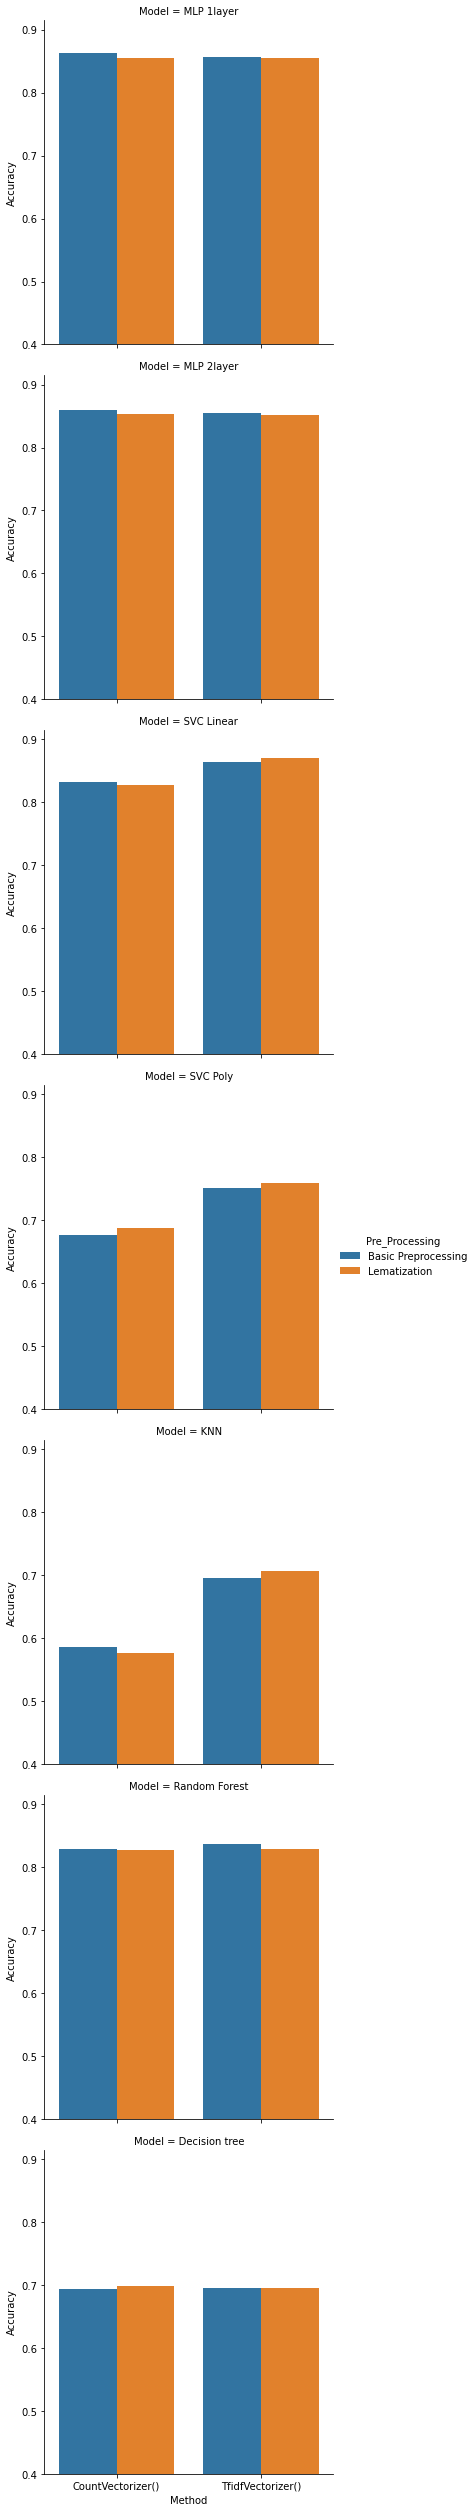

In [14]:
sb.catplot(data=dataframe, hue='Pre_Processing', y='Accuracy', x='Method', row='Model', kind='bar')
plt.ylim(0.4)

In [15]:
models = {
    'SVC Linear': SVC(kernel='linear'),
}

In [16]:
from numpy.random import randint
C = [2 ** i for i in range(-5, 16,2)]
gamma = [2 ** i for i in range(-15, 4,2)]

In [17]:
import random
gamma = random.choices(gamma, k=3)
gamma.append('scale')
gamma.append('auto')

In [18]:
C = random.choices(C, k=3)

In [19]:
params = {
    'SVC Linear': {'gamma':gamma, 'C':C },
    'MLP 1layer': {'hidden_layer_sizes':[(x, ) for x in range(2,1000)]},
    'MLP 2layer': {'hidden_layer_sizes':[(randint(50,1000), randint(50,1000)) for x in range(2,1000)]},
}

In [20]:
dataframe = pd.DataFrame()
methods = [CountVectorizer(), TfidfVectorizer()]
for i in methods:
    for index, item in enumerate(preprocessed_data):
        dataframe_aux = optimized_training(X,y,i,models,params,42,15)
        dataframe_aux['Pre_Processing'] = pre_processing[index]
        dataframe_aux['Method'] = f'{i}'
        dataframe = pd.concat([dataframe, dataframe_aux], ignore_index=True)

In [24]:
dataframe.head()

,Model,Params,Accuracy,Pre_Processing,Method
0,SVC Linear,"SVC(C=0.125, gamma=3.0517578125e-05, kernel='l...",0.8352,Basic Preprocessing,CountVectorizer()
1,SVC Linear,"SVC(C=0.125, gamma=3.0517578125e-05, kernel='l...",0.8352,Lematization,CountVectorizer()
2,SVC Linear,"SVC(C=2, gamma=3.0517578125e-05, kernel='linear')",0.8608,Basic Preprocessing,TfidfVectorizer()
3,SVC Linear,"SVC(C=2, gamma=3.0517578125e-05, kernel='linear')",0.8608,Lematization,TfidfVectorizer()


<AxesSubplot:xlabel='Method', ylabel='Accuracy'>

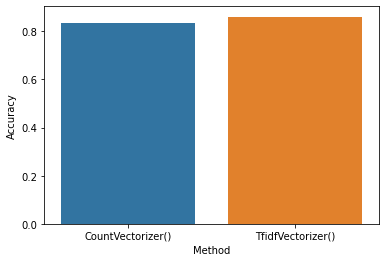

In [22]:
sb.barplot(x='Method', y='Accuracy', data=dataframe)

# Analysis Results

To classify we used default classifiers and with changes through randomized search, we obtained very satisfactory results with about 85% accuracy, but the best results were with the 1-layer MLP, using basic pre-processing and countvectorizer, with about 86, 32%, another result was the linear svc with tfidf, which remained with 86.08% and in this case random search was used